#### Practical Machine Learning 
##### File: Convolutional Neural Networks
##### Date: 02/24/2022
************************************************/   

Description:
Here is a partial dataset obtained from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
These are images of X-Rays of patient chest regions labeled with either being normal or having pneumonia
Certain patterns(such as the presentation of lobar consolidations) on the X-rays suggest the presence of pus-build up and can aid in the diagnosis of the disease.

These images have been pre-split into training, validation, and testing sets
Take a quick look through the image  s before coding to get a general idea as to the type of data we're dealing with
Can we use these images to create a model that can classify these X-ray images into Normal and Pneumonic?
Convolutional Neural Networks are a promising way to deal with such image-based data sets!

In [1]:
import warnings
warnings.filterwarnings("ignore") 

In [2]:
#General purpose imports here
import numpy as np
import glob
import os
import random
from random import shuffle

#These elow are used in image processing
import cv2
from matplotlib import pyplot as plt
from PIL import Image

#Keras/tensorflow convolutional neural network specific imports here
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.utils import np_utils
from keras import backend as K

#Below used for TensorBoard data Visualization
#from time import time
#from keras.callbacks import TensorBoard

In [3]:
# Global variables here
# Resizing of images is one of the most important preprocessing variables to consider. Generally, most freshly
# collected unprocessed images measure in the hundreds to thousands of pixels per a side.
# While mathematics of convolutions(dot-products mostly) are very quick, especially if a GPU is used, the sheer number of 
# them required to process a given image with thousands of pixels can make training time untenably long. Trimming them down
# here is one way to control the training time. The trade off to making images smaller of course is that possibly useful
# features can be lost during the process, making the resulting model less powerful. Larger images also tend to require larger
# CNN architectures
#
# The second reason to resize images is because the input tensor of most convolutional neural network layers need to be of
# the same size. If images being used are of different sizes, resizing them all to the same size prior to training is an easy
# way to solve this issue. (From what I can tell)This particular dataset does not suffer from this issue, but it's a good
# idea to keep this in mind for future datasets.
#
# Through personal experience, 32x32 to 64x64 is a pretty good size to begin with for CPU based training
# Keep in mind number of pixels increases quadratically, so doubling height and width yields a 4x increase in pixels to
# convolute, both increasing training time and memory requirement. A larger image size may also indirectly increase training
# time by increasing the model complexity required to capture relavent features

PRE_PROCESSING_IMG_SIZE_WIDTH_PIXELS = 32
PRE_PROCESSING_IMG_SIZE_HEIGHT_PIXELS = 32

MODEL_NAME =  "Pneumonia_Classification_Model"
#CWD = current working directory
CWD = os.getcwd()
#Below are the folder paths for the location of images. You can have all images in one folder and partition them
#at run time or partition them prior to run time and store them in folders. This is largely preference when dealing
#with smaller datasets, however when dealing with very large datasets, partitioning at runtime incurs heavier computational
#costs.
TRAIN_NORMAL_PATH = CWD + "\\NORMAL_TRAIN\\"
TRAIN_PNEUMONIA_PATH = CWD + "\\PNEUMONIA_TRAIN\\"
VALIDATION_NORMAL_PATH = CWD + "\\NORMAL_VALIDATION\\"
VALIDATION_PNEUMONIA_PATH = CWD + "\\PNEUMONIA_VALIDATION\\"
TEST_NORMAL_PATH = CWD + "\\NORMAL_TEST\\"
TEST_PNEUMONIA_PATH = CWD + "\\PNEUMONIA_TEST\\"

In [4]:
#Another way to increase efficiency is to convert the images to greyscale rather than color, condensing the 3 red, green,
#and blue colors to just a single black/white channel. Doing this will result in the loss of any predictive power
#based on features from color, however because the x-ray images are already black and white anyway this becomes a non-issue
#Conversion to greyscale might be a terrible idea for other datasets, do this with discretion in the future
#
#As it pertains to images, data regularization can be applied by dividing by individual pixel values(which range from 0-255)
#by 255.0 to squash the range from 0-1. This can speed up the training process, however because the resulting values are 
#floats, they will may require more memory to store compared to the original integer values. If running out of RAM
#(or GPU memory) is an issue at run time, this can be skipped to save memory.

#Preprocesses and labels images. imageType is a one-hot coding representing image type, [1,0] for normal and [0,1] for 
#pneumonic
def generateImageData(path, oneHotEncoding):
    print("Converting images from path: " + path)
    #imageData will be a list of lists
    imageData = []
    files = glob.glob(path+'*.jpeg')
    for f in files:
        #greyscale conversion here
        image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        #resizing occurs here
        image = cv2.resize(image,(PRE_PROCESSING_IMG_SIZE_WIDTH_PIXELS,PRE_PROCESSING_IMG_SIZE_HEIGHT_PIXELS))
        #Pixel value regularization done here
        image = image/255.0
        #Appends a list of a list containing the image data and it's onehotencoding which acts as a label
        imageData.append([image, oneHotEncoding])
    print("Complete!")
    return imageData

In [5]:
#Function calls to convert images made here
trainNormalData = generateImageData(TRAIN_NORMAL_PATH, [1,0])
trainPneumoniaData = generateImageData(TRAIN_PNEUMONIA_PATH, [0,1])
validationNormalData = generateImageData(VALIDATION_NORMAL_PATH, [1,0])
validationPneumoniaData = generateImageData(VALIDATION_PNEUMONIA_PATH, [0,1])
testNormalData = generateImageData(TEST_NORMAL_PATH, [1,0])
testPneumoniaData = generateImageData(TEST_PNEUMONIA_PATH, [0,1])

Converting images from path: C:\Users\sbhar\Desktop\shree\teaching\02-PML\04-Lectures\7\Exercises\CodeWalkthroughs\Extras\02-CNN-Usecase\NORMAL_TRAIN\
Complete!
Converting images from path: C:\Users\sbhar\Desktop\shree\teaching\02-PML\04-Lectures\7\Exercises\CodeWalkthroughs\Extras\02-CNN-Usecase\PNEUMONIA_TRAIN\
Complete!
Converting images from path: C:\Users\sbhar\Desktop\shree\teaching\02-PML\04-Lectures\7\Exercises\CodeWalkthroughs\Extras\02-CNN-Usecase\NORMAL_VALIDATION\
Complete!
Converting images from path: C:\Users\sbhar\Desktop\shree\teaching\02-PML\04-Lectures\7\Exercises\CodeWalkthroughs\Extras\02-CNN-Usecase\PNEUMONIA_VALIDATION\
Complete!
Converting images from path: C:\Users\sbhar\Desktop\shree\teaching\02-PML\04-Lectures\7\Exercises\CodeWalkthroughs\Extras\02-CNN-Usecase\NORMAL_TEST\
Complete!
Converting images from path: C:\Users\sbhar\Desktop\shree\teaching\02-PML\04-Lectures\7\Exercises\CodeWalkthroughs\Extras\02-CNN-Usecase\PNEUMONIA_TEST\
Complete!


In [6]:
#Sample populations shown here. Because the sample sizes are imbalanced, over and undersampling could be an option
#These sample sizes are on the smaller side, so I've decided against it for now, but it might be worth trying in the future
print("Training Normal Sample Size: " + str(len(trainNormalData)))
print("Training Pneumonia Sample Size: " + str(len(trainPneumoniaData)))
print("Validation Normal Sample Size: " + str(len(validationNormalData)))
print("Validation Pneumonia Sample Size: " + str(len(validationPneumoniaData)))
print("Test Normal Sample Size: " + str(len(testNormalData)))
print("Test Pneumonia Sample Size: " + str(len(testPneumoniaData)))

Training Normal Sample Size: 1081
Training Pneumonia Sample Size: 2121
Validation Normal Sample Size: 130
Validation Pneumonia Sample Size: 380
Test Normal Sample Size: 130
Test Pneumonia Sample Size: 380


In [7]:
print("Test Pneumonia Sample Size: " + str(len(testPneumoniaData)))

Test Pneumonia Sample Size: 380


Normal Example: 


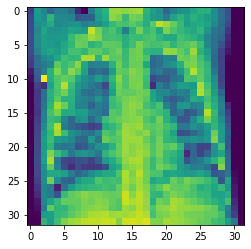

Pneumonia Example: 


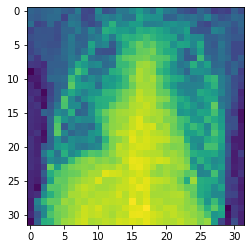

In [8]:
#Some example images after processing, note how small they actually are compared to the original
print("Normal Example: ")
plt.imshow(testNormalData[0][0], interpolation='nearest')
plt.show()
print("Pneumonia Example: ")
plt.imshow(testPneumoniaData[0][0], interpolation='nearest')
plt.show()

In [9]:
#Combine the processed data and shuffle here. Shuffling is important! Set the random seed if reproducibility is of 
#importance, which it is during the development/debugging phase. 
random.seed(82)

trainData = trainNormalData + trainPneumoniaData
random.shuffle(trainData)
validationData = validationNormalData + validationPneumoniaData
random.shuffle(validationData)
testData = testNormalData + testPneumoniaData
random.shuffle(testData)

In [10]:
#Example of functions that saves and load the model. The .json file dictates the architecture, while the .h5 file 
#has the weights information. Using these two it is possible to do transfer learning with predetermined weights with 
#different models.
def saveModel():
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights("model.h5")
    print("Saved model to disk")

def loadModel():
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("model.h5")
    print("Loaded model from disk")
    return loaded_model

In [11]:
#Parses data into imageData and labelData
def generateImageAndLabelData(data):
    imageData = []
    labelData = []
    
    for i in range(len(data)):
        imageData.append(data[i][0])
        labelData.append(data[i][1])
        
    #Convert list type to numpy array type for easier manipulation
    imageData = np.array(imageData)
    labelData = np.array(labelData)
    
    #Additional reshaping to ensure data has the expected number of tensor dimensions. Sometimes during image conversion,
    #especially with greyscales, because there is only 1 color channel, the 1 is dropped and a 2D tensor is returned
    #instead of the 3D tensor, which will cause an error with most CNN models
    imageData = imageData.reshape(imageData.shape[0], PRE_PROCESSING_IMG_SIZE_WIDTH_PIXELS,PRE_PROCESSING_IMG_SIZE_HEIGHT_PIXELS,1)
    
    return imageData, labelData

In [12]:
#Last step in data pre-processing
trainImages, trainLabels = generateImageAndLabelData(trainData)
validationImages, validationLabels = generateImageAndLabelData(validationData)
testImages, testLabels = generateImageAndLabelData(testData)

In [13]:
#Here I am using the Keras API to configure the layers.

#Below is a pretty typical model with 6 convolutional layers and 2 maxpool layers. Architectures can get very large
#and complicated with hundreds or thousands of layers. There are a lot of nuances that would be difficult to fully
#explain here. General notes though regarding basic layer purposes:

#1. Convolutional layers create feature maps. Tends to be the largest contributor to computational time in most modern 
#architectures. FilterSize(Filter Quantity) scales linearly with computational resource used, however from literature, 
#general sentiment seems to be that simple features generated early on are not as useful as the complex ones generated later
#in terms of creating a discrimitory model, and thus filtersizes tend to start low and grow gradually as move convolutions
#are involved and more complex features captured. As with almost all hyperparameters, they tend to increase by a factor of 2
#due to computational efficiency

#2. Layers with strides of greater than 1x1 will result in dimensionality reduction, used to control parameter 
#quantity/training speed, usually in conjunction with pooling layers. Asymmetrical strides(1x3 or 3x1) are occasionally
#used in situations where images are rectangular and sparse - also used in more advanced models(Inception v2+ and its
#variants come to mind).

#3. Pooling layers are used to condense information of an area of tensors into a single value. Generally speaking 
#use one of these every once every several convolutional layers, and not next to each other(use a single pooling 
#layer with larger stride steps to achieve similar effect with less calculations). Very handy for reducing parameters. For
#whatever reason there seems to be a preference for Max Pooling over Average Pooling, but both can work. Be aware that
#because pooling layers reduce dimensionality, errors will be thrown if a given pooling window exceeds the tensor size

#3. Normalization layers(generally batch normalization and/or dropout layers) can help with overfitting/training speed,
#dropout has fallen out of favor the past couple of years. If you choose to use a dropout layer, apply to only fully
#connected layers, or use a small dropout ratio(.1 or less). Probably just use batch normalization instead if you're just
#starting out.

#4. There are many activation functions, the most popular is ReLU with and it's variants(Such as Elu/PreLu) with default
#hyperparameters and SGD with the tuned hyperparameters

#5. Window Size, or Kernal Size, is typically a function of the size of the tensor being convolved. Many models which deal 
#with tensor inputs of large sizes will have window sizes of 7+ in the early layers(sometimes called input stems). Window
#size dimensions tend to be odd(3x3,5x5,7x7 are common), however I personally have no see research regarding the efficacy of
#even numbered dimensions - from personal experience they can work just as well. I am not aware of any use of window sizes 
#of 1x1 for pooling layers. 1x1 windows for convolutional layers however can be used in certain models for the purposes of 
#dimensionality reduction(Inception modules and its variants from GoogleNet uses these).

def generateModel():
    #This is a binary problem, either normal or pneumonic, so number is 2
    categoryQuant = 2
    #input layer - note the 1 is because of greyscaling, it would be a 3 if colored images were being used
    input_layer = Input(shape = (PRE_PROCESSING_IMG_SIZE_WIDTH_PIXELS, PRE_PROCESSING_IMG_SIZE_HEIGHT_PIXELS,1))
    
    filterSize = 32
    conv1 = Conv2D(filterSize, (3,3), strides=(1,1), padding='same')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation("elu")(conv1)
    conv1 = Conv2D(filterSize, (3,3), strides=(1,1), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation("elu")(conv1)

    maxPool1 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(conv1)
    
    filterSize = 64
    conv2 = Conv2D(filterSize, (3,3), strides=(1,1), padding='same')(maxPool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation("elu")(conv2)
    conv2 = Conv2D(filterSize, (3,3), strides=(1,1), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation("elu")(conv2)
    
    maxPool2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(conv2)
    
    filterSize = 128
    conv3 = Conv2D(filterSize, (3,3), strides=(1,1), padding='same')(maxPool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation("elu")(conv3)
    conv3 = Conv2D(filterSize, (3,3), strides=(1,1), padding='same')(maxPool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation("elu")(conv3)
    
    #Older models(prior to Googlenet) used a stack of 2 or 3 fully connected layers in the output stem. Modern models
    #tend to avoid the use of fully connected layers to decrease parameters used.
    #What is sometimes called "Global Average Pooling" is used here. Unlike normal pooling layers, the stride size is 1x1
    #and thus no dimension reduction takes place here, rather it is used to enforce correspondence between feature maps
    #generated in the prior convolutional layers and categorization during the softmax process. It is used in conjunction
    #with a Flatten layer.
    outputStem = AveragePooling2D(pool_size=(3,3), strides=(1,1), padding='same')(conv3)
    outputStem = Flatten()(outputStem)
    
    #Note that the final layer is always dense, and because this is a categorization problem, the activation function is
    #softmax
    outputStem = Dense(categoryQuant, activation='softmax')(outputStem)
    
    #This final step is specific to the Keras API method, where the tensor representation is converted to a model
    model = Model(inputs = input_layer, outputs = outputStem)
    return model

In [14]:
model = generateModel()
print(model.summary())

#Output shape can be important when attempting to add or concatenate layers, and here is a good place to check
#If time to train is an issue, checking here for where sources of large amount of parameters is also a good idea

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0     

In [15]:
#From personal experience, .001 is a good place to start for LR, however from literature I've seen as high as .1 and as
#low as 1e-7. There seems to be a negative correlation between number of parameters and learning rate.
#Epochnum and 
learningRate = .001

#Epochs trained can be highly variable - in general stop training early when you see val_loss plateaus or starts decreasing
#An optimized learning rate/other hyper parameters can also decrease number of epochs required to train
epochNum = 12
batchSize = 64

model.compile(keras.optimizers.Adam(lr=learningRate),metrics=["accuracy"],loss="categorical_crossentropy")
history = model.fit(trainImages, trainLabels, validation_data=(validationImages, validationLabels), epochs=epochNum, batch_size=batchSize, verbose=1)
accuracy_scores = model.evaluate(validationImages, validationLabels, verbose=1)

Epoch 1/12
51/51 [==============================] - 15s 287ms/step - loss: 0.3776 - accuracy: 0.8910 - val_loss: 1.5716 - val_accuracy: 0.7451
Epoch 2/12
51/51 [==============================] - 18s 346ms/step - loss: 0.2473 - accuracy: 0.9204 - val_loss: 2.0280 - val_accuracy: 0.7451
Epoch 3/12
51/51 [==============================] - 19s 375ms/step - loss: 0.0787 - accuracy: 0.9694 - val_loss: 2.9308 - val_accuracy: 0.7451
Epoch 4/12
51/51 [==============================] - 18s 348ms/step - loss: 0.0645 - accuracy: 0.9747 - val_loss: 3.4418 - val_accuracy: 0.7451
Epoch 5/12
51/51 [==============================] - 17s 337ms/step - loss: 0.0433 - accuracy: 0.9844 - val_loss: 2.4165 - val_accuracy: 0.7451
Epoch 6/12
51/51 [==============================] - 16s 313ms/step - loss: 0.0426 - accuracy: 0.9834 - val_loss: 3.3706 - val_accuracy: 0.7451
Epoch 7/12
51/51 [==============================] - 15s 294ms/step - loss: 0.0233 - accuracy: 0.9919 - val_loss: 2.1323 - val_accuracy: 0.7451

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


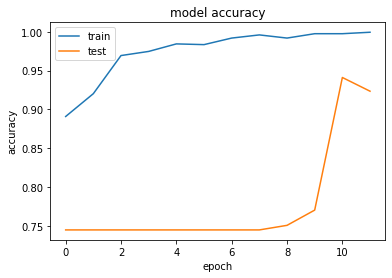

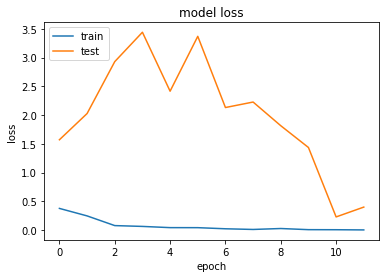

In [16]:
#Here we can see a summary of the training process to make judgements. Is there overfitting? Is there underfitting? 
#Overfitting is typically characterized by a large gap between training loss and validation loss, as well as increasing
#validation loss after initially decreasing. Underfitting is characterized by situations where validation loss is
#significantly less than(val_acc greater than) the training sample's.

print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
#Here we see how well the model performs on data it's never seen before, the test data set!
accuracy_scores = model.evaluate(testImages, testLabels, verbose=1)
print("Test Sample Loss: " + str(accuracy_scores[0]))
print("Test Sample Accuracy: " + str(accuracy_scores[1]))

16/16 [==============================] - 0s 24ms/step - loss: 0.2578 - accuracy: 0.9314
Test Sample Loss: 0.25779736042022705
Test Sample Accuracy: 0.9313725233078003


In [18]:
#Save model for future use or training - the way this function is written at the moment overwrites and saves as model.json
#and model.h5
saveModel()

Saved model to disk
